# Trending Youtube Video Statistics

The dataset was taken from [https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv](https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv)

## Preparation

### Import Libraries

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import sys
import warnings
import pickle

from IPython.core.interactiveshell import InteractiveShell
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version:  1.20.3
pandas version:  1.3.4
seaborn version:  0.11.2
last run:  2021-12-29 02:33:33


### Loading Dataset

In [60]:
df = pd.read_csv('USvideos.csv')

# developer-friendly column names and format
df.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in df.columns.to_list()]

### Variables and Functions

In [61]:
binary_pallete = ['#EF4444', '#10B981']

## Data Information & Description

### Data Sample

In [62]:
df.sample(5, random_state=1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
22745,00RpZZThSAs,18.09.03,How Good is McDonald's New Szechuan Sauce?,TheReportOfTheWeek,24,2018-02-26T16:44:55.000Z,"szechuan|""szechuan sauce""|""rick and morty""|""mc...",1198888,37595,2794,6941,https://i.ytimg.com/vi/00RpZZThSAs/default.jpg,False,False,False,Trying out the new Szechuan Sauce from McDonal...
33187,1Aoc-cd9eYs,18.07.05,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02T16:02:35.000Z,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",672609,4916,197,1269,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...
12833,_zu53yAoTJE,18.19.01,U2 - Get Out Of Your Own Way (Official Video),U2VEVO,10,2018-01-18T16:00:02.000Z,"U2|""Get""|""Out""|""Of""|""Your""|""Own""|""Way""|""Island...",134003,5430,1601,1427,https://i.ytimg.com/vi/_zu53yAoTJE/default.jpg,False,False,False,'Get Out Of Your Own Way’ from the new album ‘...
25194,EL1wN_ihL_E,18.22.03,Jurassic Park Auditions - SNL,Saturday Night Live,24,2018-03-18T11:16:05.000Z,"bill hader|""snl""|""s43""|""s43e16""|""episode 16""|""...",2181976,32457,1420,1349,https://i.ytimg.com/vi/EL1wN_ihL_E/default.jpg,False,False,False,"Hugh Grant (Alex Moffat), Alan Alda (Bill Hade..."
7802,cMD63TwzB1o,17.23.12,SZA - The Weekend (Official Video),SZAVEVO,10,2017-12-22T05:00:01.000Z,"R&B|""SZA""|""The Weekend""|""Top Dawg Entertainmen...",1292926,77746,6945,11701,https://i.ytimg.com/vi/cMD63TwzB1o/default.jpg,False,False,False,SZA's CTRL available on:\nApple Music - http:/...


### Data Information

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

- Features with missing value:
    - `description`
- Feature with binary/boolean value:
    - `comments_disabled`
    - `ratings_disabled`
    - `video_error_or_removed`

## Preprocessing

### Removing Unnecessary Features

In [64]:
df.drop(['video_id', 'thumbnail_link', 'description', 'trending_date', 'publish_time', 'tags'], axis=1, inplace=True)

### Removing Duplicated Data

In [65]:
print("before removal:", df.shape[0])

print("duplicated count:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

print("after removal:", df.shape[0])

before removal: 40949
duplicated count: 48
after removal: 40901


### Preprocessing Result

In [66]:
df.sample(5, random_state=1)

,title,channel_title,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
34596,Enrique Iglesias - MOVE TO MIAMI (Lyric Video)...,EnriqueIglesiasVEVO,10,3424478,79048,3650,4037,False,False,False
32326,"I LOST $10,000 twice",itsAlexClark,1,1205222,30241,3031,4649,False,False,False
33208,How to pick up a cat like a pro - Vet advice o...,Helpful Vancouver Vet,15,2199352,71653,1758,6891,False,False,False
30233,Liam Payne Goes Sneaker Shopping With Complex,Complex,24,1122136,29314,1138,2844,False,False,False
11637,Camila Cabello - Something's Gotta Give (Audio),CamilaCabelloVEVO,10,1063285,98220,635,4662,False,False,False


## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [67]:
df.select_dtypes(include='number').describe()

,category_id,views,likes,dislikes,comment_count
count,40901.000000,4.090100e+04,4.090100e+04,4.090100e+04,4.090100e+04
mean,19.970588,2.360678e+06,7.427173e+04,3.711722e+03,8.448567e+03
std,7.569362,7.397719e+06,2.289999e+05,2.904624e+04,3.745139e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.419720e+05,5.416000e+03,2.020000e+02,6.130000e+02
50%,24.000000,6.810640e+05,1.806900e+04,6.300000e+02,1.855000e+03
75%,25.000000,1.821926e+06,5.533800e+04,1.936000e+03,5.752000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


#### Categorical

In [68]:
df.select_dtypes(exclude='number').describe()

,title,channel_title,comments_disabled,ratings_disabled,video_error_or_removed
count,40901,40901,40901,40901,40901
unique,6455,2207,2,2,2
top,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,ESPN,False,False,False
freq,29,202,40269,40732,40878


- binary features: `comments_disabled`, `ratings_disabled`, `video_error_or_removed`

### Univariate Analysis

#### Distribution

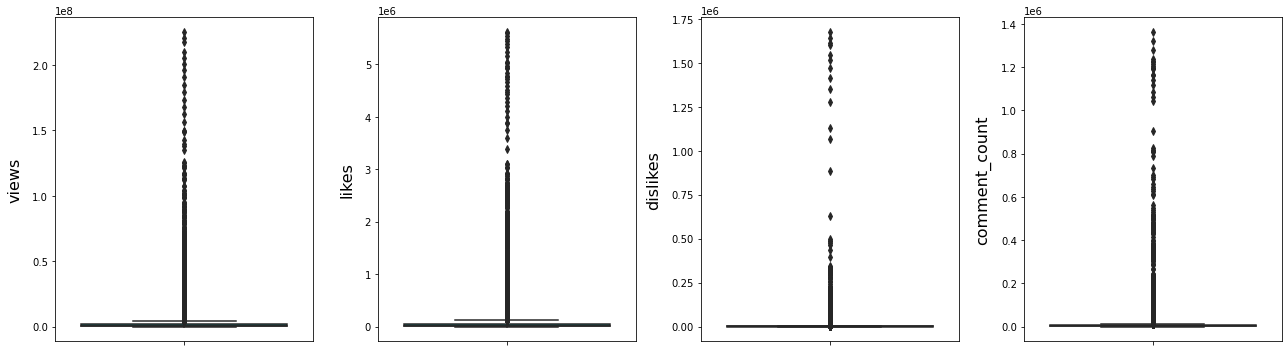

In [69]:
idf = df.select_dtypes(include='number')
idf.drop(['category_id'], axis=1, inplace=True)
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=df[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

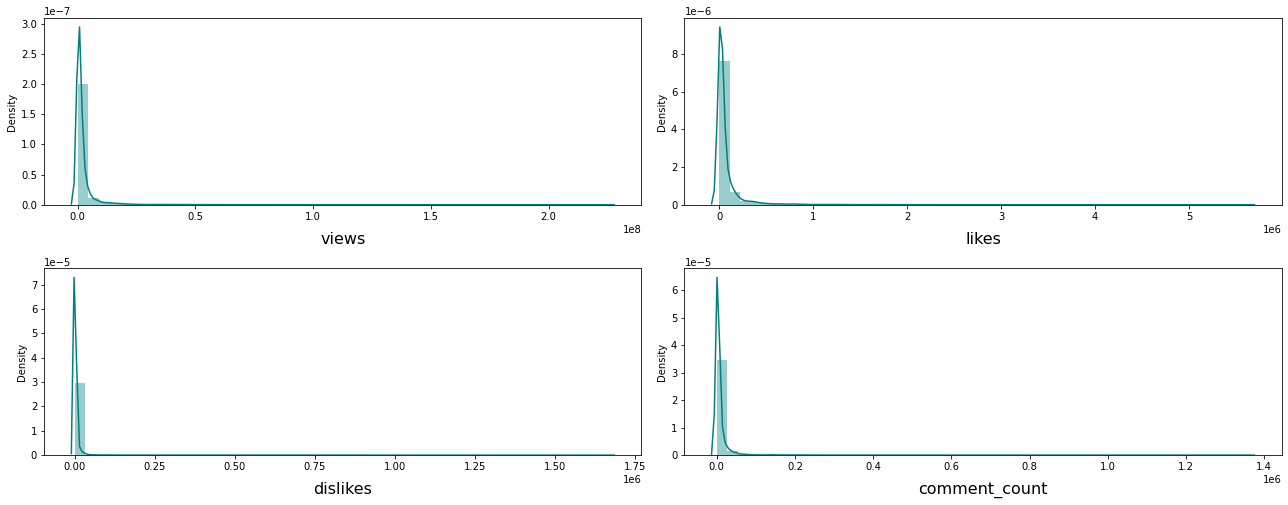

In [70]:
idf = df.select_dtypes(include='number')
idf.drop(['category_id'], axis=1, inplace=True)
cols = idf.columns.to_list()

plt.figure(figsize=(18, 10))
for index in range(0, len(cols)):
    plt.subplot(3, len(cols)/2, index+1)
    sns.distplot(df[cols[index]], color='teal')
    plt.xlabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

- The distribution for `views`, `likes`, `dislikes`, and `comment_count` has median centered near 0 value and has deviating outliers.

#### Comparison

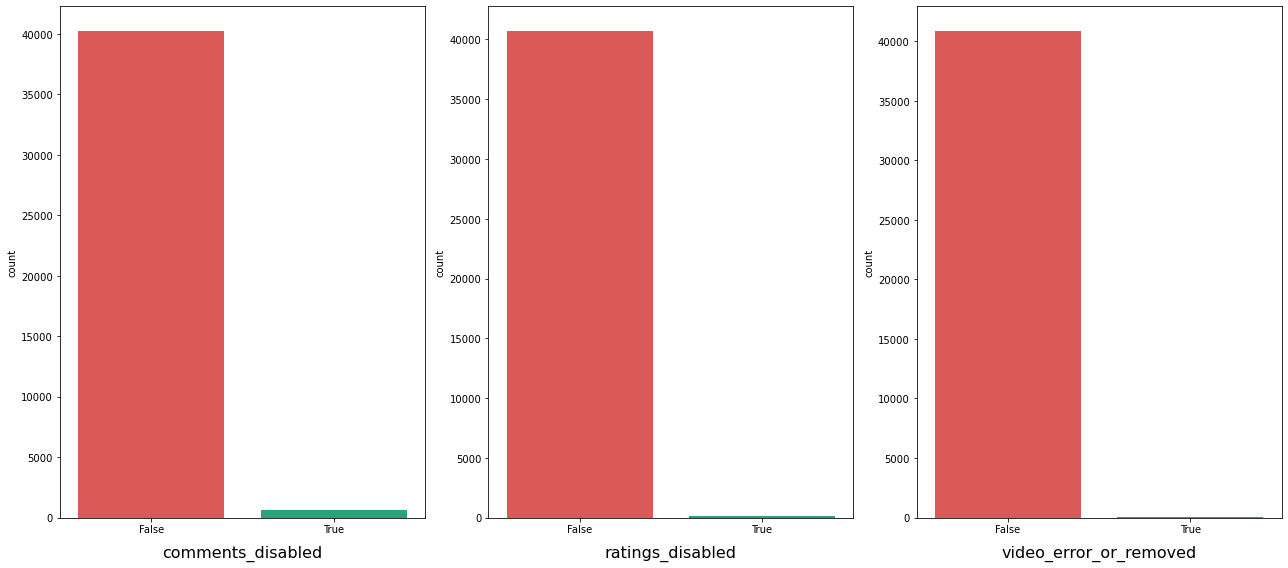

In [71]:
binary_features = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']

plt.figure(figsize=(18, 8))
for index in range(0, len(binary_features)):
    plt.subplot(1, 3, index+1)
    sns.countplot(df[binary_features[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(binary_features[index], fontsize='16', labelpad=10)

plt.show();

- All the binary features has class imbalance with `False` dominating over `True` value.

### Multivariate Analysis

#### Correlation Heatmap

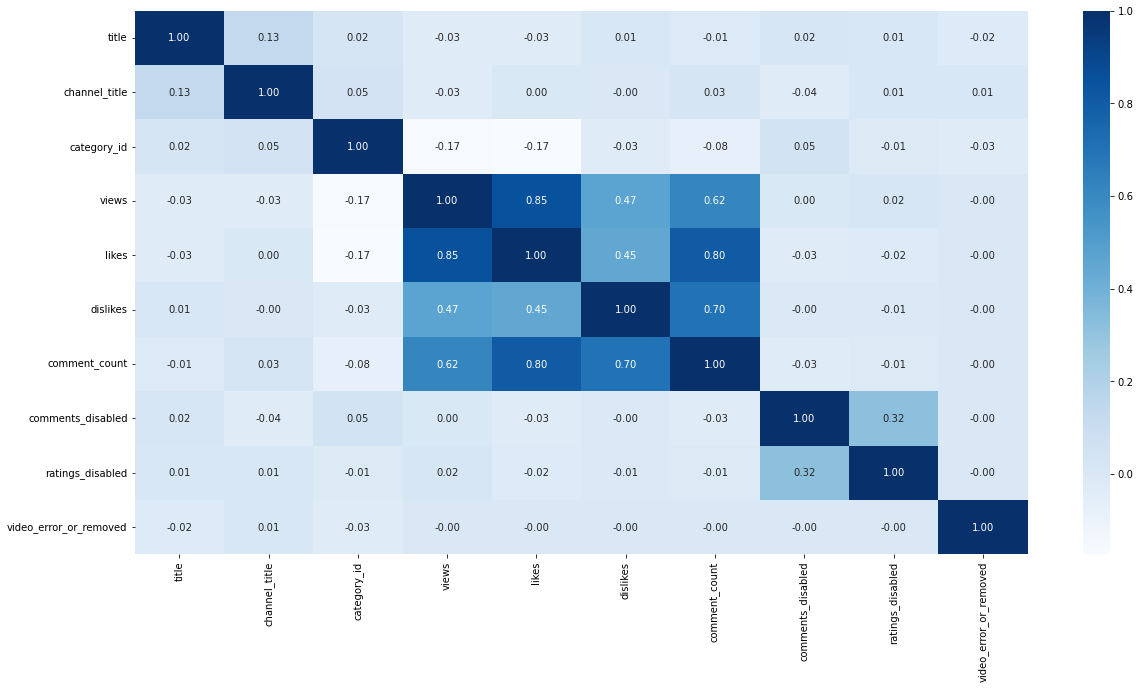

In [72]:
# label encoding for heatmap
idf = df.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

#### Pairplot

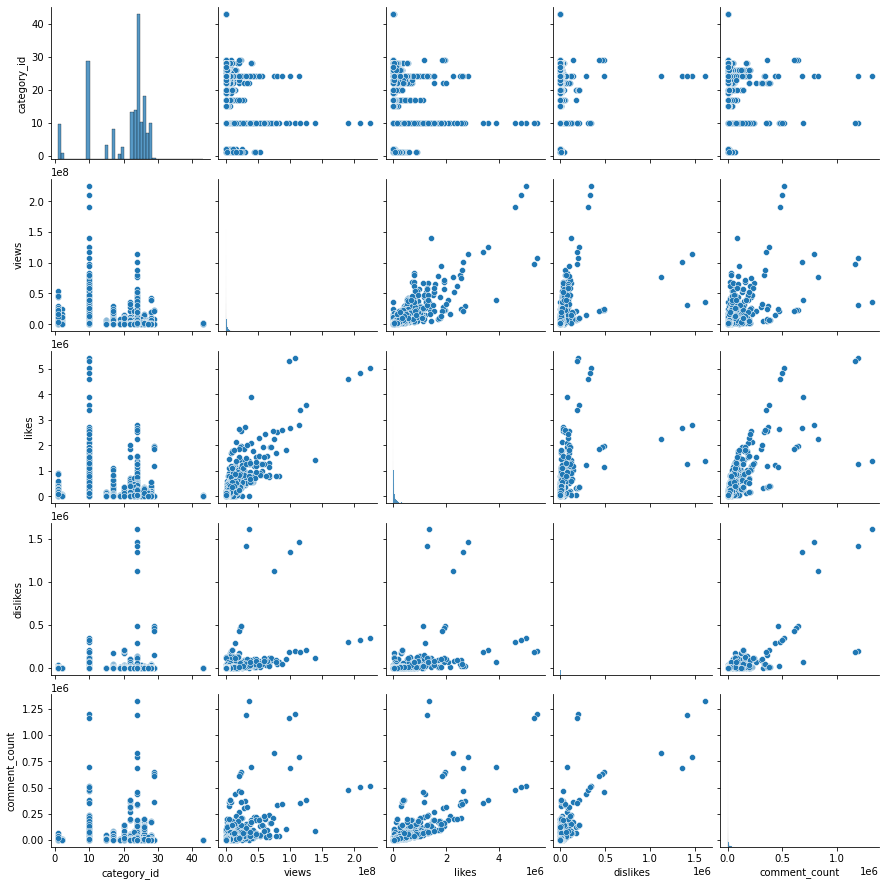

In [75]:
sns.pairplot(data=df.select_dtypes(include='number').sample(20000, random_state=1))
plt.show();